<a href="https://colab.research.google.com/github/ccasella-usd/Energy-Efficiency/blob/main/notebooks/AAI_500_Final_Project_Group3_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAI500 Final Project
## Energy Prediction

### Group 3
### Name : Ashley Figueroa
### Name : Robert Shifrin
### Name : Carlo Casella
#### Date : 10 February 2026

This research project focused on developing data-driven predictive models for the energy consumption of appliances in a low-energy "passive" house located in Belgium. The study aimed to identify the most significant environmental and temporal predictors of energy use to improve building performance simulations and energy management.

Appliance Energy Prediction

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters.
(https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction)




##### Energy Consumption Codes
Appliances: Aggregate electrical energy consumption of all appliances in the house (Wh).
Lights: Sub-metered electrical energy consumption of light fixtures (Wh).
Indoor Environment Codes (T = Temperature, RH = Humidity)

##### Zones or Rooms
• T1 / RH1: Kitchen area.
• T2 / RH2: Living room area.
• T3 / RH3: Laundry room area.
• T4 / RH4: Office room.
• T5 / RH5: Bathroom.
• T7 / RH7: Ironing room.
• T8 / RH8: Teenager room 2.
• T9 / RH9: Parents room.


##### Weather and Outdoor Codes

• T6 / RH6: Temperature and humidity measured immediately outside the building on the north side.
• To / RHo: Temperature and humidity from the Chièvres weather station.
• Pressure: Atmospheric pressure (mm Hg).
• Windspeed: Wind speed (m/s).
• Visibility: Visibility (km).
• Tdewpoint: Dew point temperature (°C)

##### Time and Statistical Codes
• NSM: Number of Seconds from Midnight; this was identified as the most important predictor for appliance energy use.
• WeekStatus: A categorical variable indicating if the day is a weekday or weekend.
• Day_of_week: The specific day (Monday, Tuesday, etc.).
• RV1 / RV2: Random variables introduced by the researchers to test the effectiveness of their feature selection algorithms


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Read in the data and display the first 5 rows
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
energydata = pd.read_csv(url)
energydata.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
#convert 'date' column to datetime objects
energydata['date'] = pd.to_datetime(energydata['date'])

In [ ]:
#Add time series resolution columns to the data frame
energydata['weekday'] = energydata['date'].dt.day_name().str[:3]
energydata['is_weekend'] = energydata['weekday'].isin(['Sat', 'Sun'])
energydata['day_type'] = np.where(energydata['is_weekend'], 'Weekend', 'Weekday')
energydata['hour'] = energydata['date'].dt.hour


#Number of seconds from midnight NSM
energydata['NSM'] = (energydata['date'] - energydata['date'].dt.normalize()).dt.total_seconds()
energydata['log_Appliances'] = np.log1p(energydata['Appliances'])


In [ ]:
# --- Feature engineering for better performance (time-series) ---
# Adds cyclical time encodings + lag/rolling features for Appliances.
# IMPORTANT: rolling features use shift(1) to avoid leakage (only past data).

energydata = energydata.sort_values("date").reset_index(drop=True).copy()

# Cyclical time of day (minutes since midnight)
energydata["minute"] = energydata["date"].dt.minute
energydata["tod_minutes"] = energydata["hour"] * 60 + energydata["minute"]
energydata["tod_sin"] = np.sin(2 * np.pi * energydata["tod_minutes"] / 1440)
energydata["tod_cos"] = np.cos(2 * np.pi * energydata["tod_minutes"] / 1440)

# Day-of-week cyclical encoding (0=Mon ... 6=Sun)
energydata["dow"] = energydata["date"].dt.dayofweek
energydata["dow_sin"] = np.sin(2 * np.pi * energydata["dow"] / 7)
energydata["dow_cos"] = np.cos(2 * np.pi * energydata["dow"] / 7)

# Lags (10-min intervals): 1=10min, 6=1hr, 18=3hr, 144=24hr
for lag in [1, 6, 18, 144]:
    energydata[f"Appliances_lag_{lag}"] = energydata["Appliances"].shift(lag)

# Rolling means/stdev using ONLY past values (shift(1) prevents leakage)
for win in [6, 18, 144]:
    energydata[f"Appliances_rollmean_{win}"] = energydata["Appliances"].shift(1).rolling(win).mean()
    energydata[f"Appliances_rollstd_{win}"] = energydata["Appliances"].shift(1).rolling(win).std()

# Drop rows created by lag/rolling
energydata = energydata.dropna().reset_index(drop=True)


In [ ]:
energydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19591 entries, 0 to 19590
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     19591 non-null  datetime64[ns]
 1   Appliances               19591 non-null  int64         
 2   lights                   19591 non-null  int64         
 3   T1                       19591 non-null  float64       
 4   RH_1                     19591 non-null  float64       
 5   T2                       19591 non-null  float64       
 6   RH_2                     19591 non-null  float64       
 7   T3                       19591 non-null  float64       
 8   RH_3                     19591 non-null  float64       
 9   T4                       19591 non-null  float64       
 10  RH_4                     19591 non-null  float64       
 11  T5                       19591 non-null  float64       
 12  RH_5                     19591 n

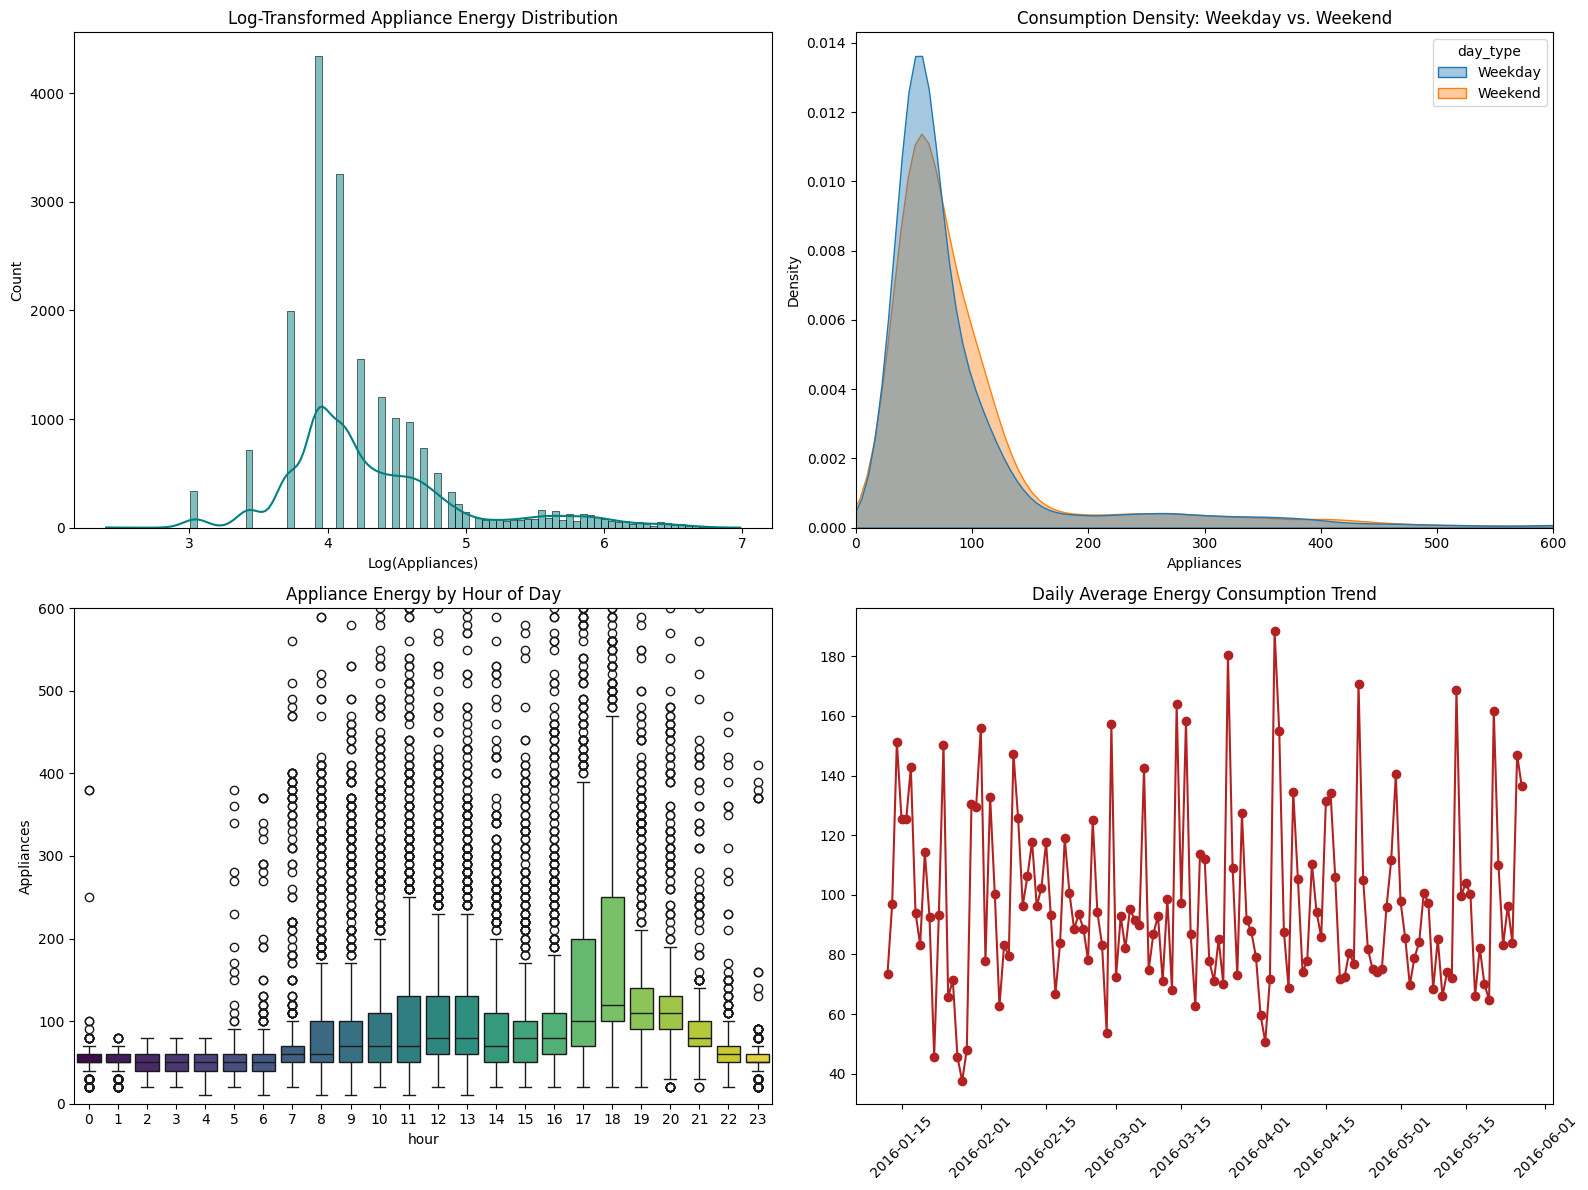

In [ ]:
# Prepare Figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3)

# --- PLOT 1: Log-Transformed Distribution (Essential for Linear Models) ---
sns.histplot(energydata['log_Appliances'], kde=True, ax=axes[0, 0], color='teal')
axes[0, 0].set_title('Log-Transformed Appliance Energy Distribution', fontsize=12)
axes[0, 0].set_xlabel('Log(Appliances)')

# --- PLOT 2: Density by Day Type (Weekdays vs Weekends) ---
sns.kdeplot(data=energydata, x='Appliances', hue='day_type', fill=True,
            common_norm=False, alpha=0.4, ax=axes[0, 1])
axes[0, 1].set_title('Consumption Density: Weekday vs. Weekend', fontsize=12)
axes[0, 1].set_xlim(0, 600) # Limiting x-axis to see the main distribution clearly

# --- PLOT 3: Hourly Boxplot (The "Behavioral" Predictor) ---
sns.boxplot(x='hour', y='Appliances', data=energydata, ax=axes[1, 0],
            hue='hour', palette='viridis', legend=False) # Added hue and legend=False
axes[1, 0].set_title('Appliance Energy by Hour of Day', fontsize=12)
axes[1, 0].set_ylim(0, 600)

# --- PLOT 4: Daily Average Trend (The Time-Series View) ---
daily_avg = energydata.groupby(energydata['date'].dt.date)['Appliances'].mean()
axes[1, 1].plot(daily_avg.index, daily_avg.values, marker='o', linestyle='-', color='firebrick')
axes[1, 1].set_title('Daily Average Energy Consumption Trend', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

`Rationale for EDA Model Selection`

`I selected this set of EDA visualizations to ensure our modeling decisions are grounded in statistical validity and interpretability. First, I did a log-transformed histogram of Appliances because the raw consumption data is right-skewed, which violates normality assumptions required for linear regression. (something we learned from this week's topic) Applying the log transformation allows us to visually confirm improved symmetry and assess whether linear modeling assumptions are more reasonable.`

`Second, I retained Carlo’s density plot comparing weekday vs. weekend consumption because it provides a clear probabilistic comparison of behavioral differences across day types. Rather than simply comparing means, the KDE visualization shows the full distribution, highlighting differences in spread, peak concentration, and tail behavior. This directly supports feature engineering decisions such as including day-type indicators in the model.`

`Third, the hourly boxplot captures intra-day variability and reveals strong time-of-day effects in energy consumption. The clear shifts in median and dispersion across hours suggest that “hour” functions as a behavioral predictor and justifies its inclusion as a temporal feature.`

`Finally, the daily average time-series plot provides a macro-level temporal trend, allowing us to visually inspect seasonality, drift, and volatility over time. This supports evaluating whether temporal aggregation improves model stability and whether autocorrelation should be considered in future modeling iterations.`

`All plots were organized side-by-side to enhance interpretability, maintain narrative flow in the notebook, and visually connect distributional assumptions with temporal dynamics and segmentation insights. Together, these visualizations directly inform feature selection and validate the appropriateness of regression-based modeling for the energy efficiency objective.`

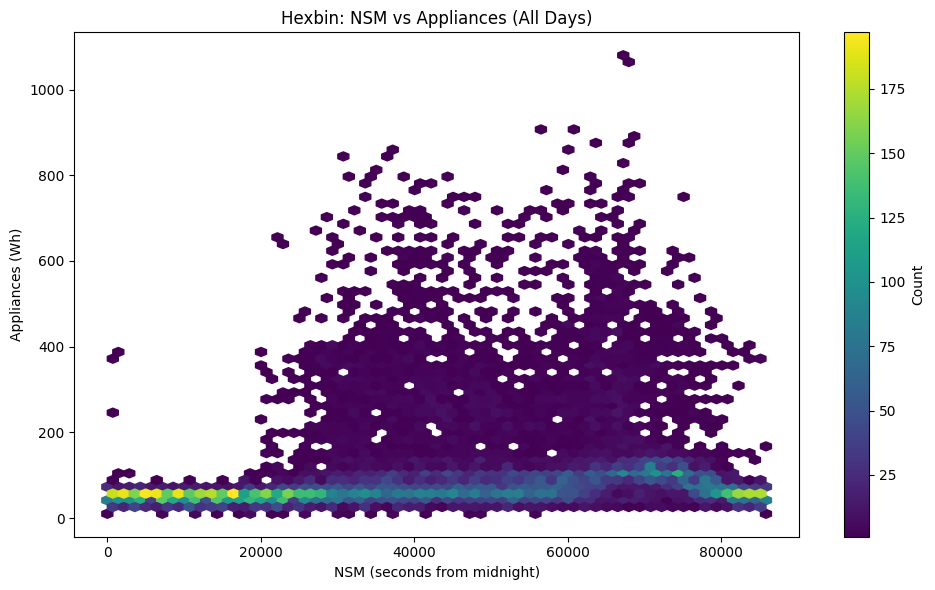

In [ ]:
plt.figure(figsize=(10, 6))
plt.hexbin(
    energydata['NSM'],
    energydata['Appliances'],
    gridsize=60,
    cmap='viridis',
    mincnt=1
)
plt.colorbar(label='Count')
plt.title('Hexbin: NSM vs Appliances (All Days)')
plt.xlabel('NSM (seconds from midnight)')
plt.ylabel('Appliances (Wh)')
plt.tight_layout()
plt.show()




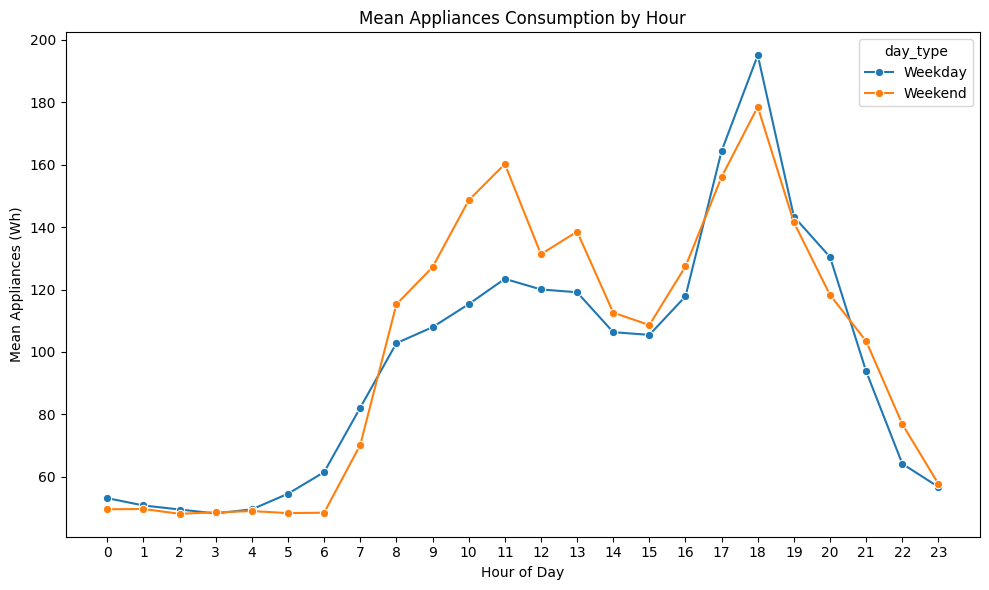

In [ ]:
#Time of day Appliance consumption per hour
mean_by_hour = (
    energydata.groupby(['hour', 'day_type'])['Appliances']
      .mean()
      .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=mean_by_hour,
    x='hour',
    y='Appliances',
    hue='day_type',
    marker='o'
)
plt.title('Mean Appliances Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Appliances (Wh)')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()



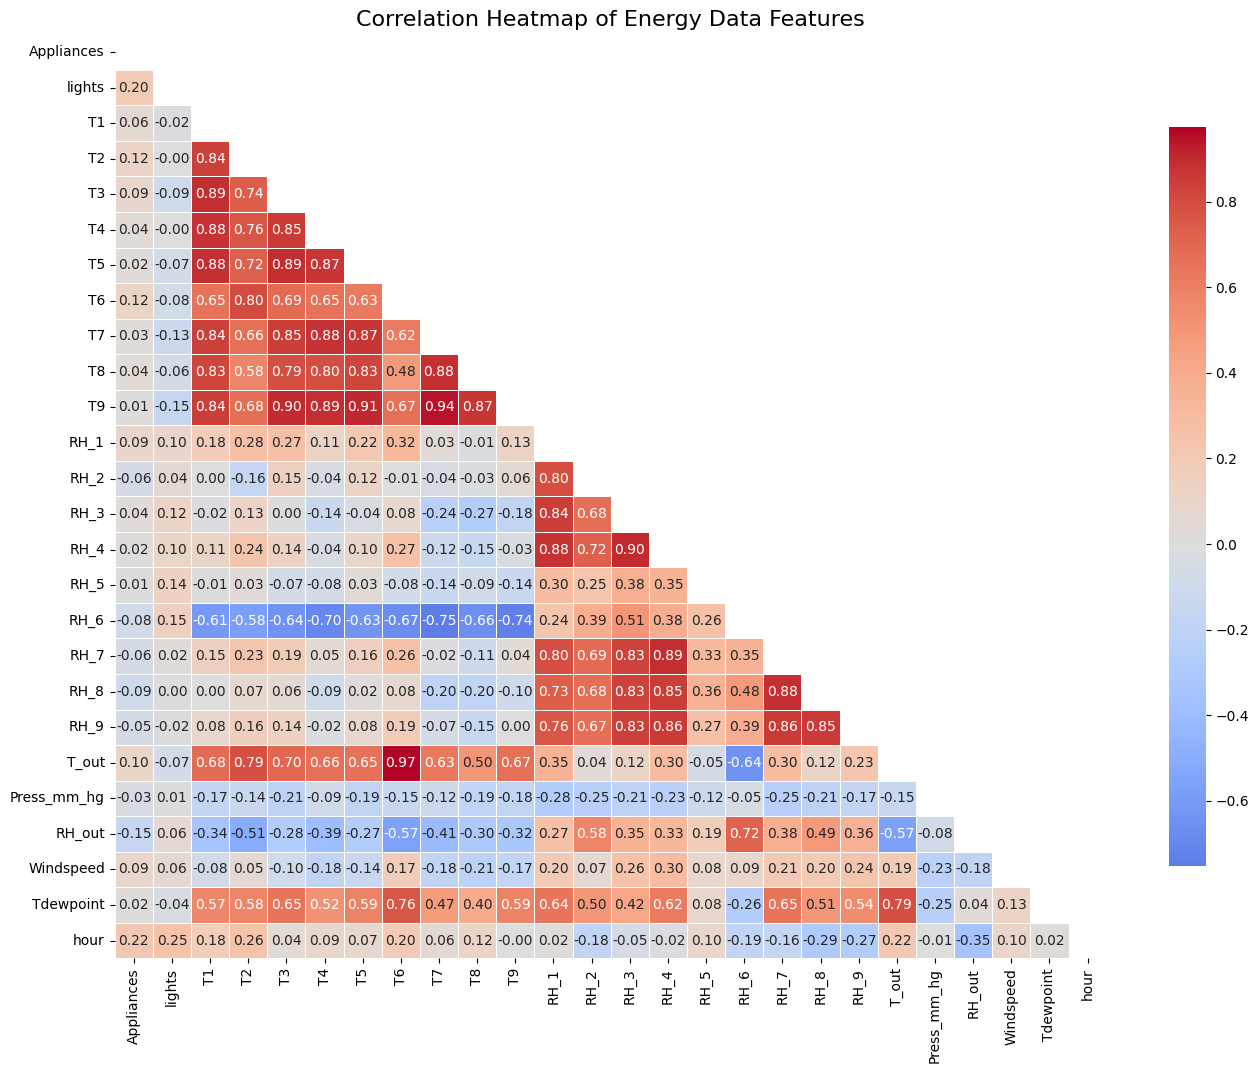

In [ ]:
# 1. Select the columns for the correlation matrix
# We exclude 'rv1', 'rv2' as they are random noise and 'NSM' as it correlates with 'hour'
cols_to_corr = [
    'Appliances', 'lights', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
    'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9',
    'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint', 'hour'
]

corr_matrix = energydata[cols_to_corr].corr()

# 2. Setup the figure
plt.figure(figsize=(16, 12))

# 3. Create a mask to hide the upper triangle (it's a mirror of the bottom)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 4. Plot Heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            center=0, linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap of Energy Data Features', fontsize=16)
plt.show()

`I added the correlation heatmap so we can clearly see how all predictors relate to each other and to Appliances before locking in our model. Based on the heatmap, several temperature sensors (T1–T9) are highly correlated with one another, which suggests multicollinearity could become an issue if we use standard multiple linear regression. We also see that individual predictors have relatively modest linear relationships with Appliances, meaning the signal is likely distributed across multiple correlated features rather than coming from a single dominant variable.`

`Although NSM and hour encode similar time-of-day information, we retain time encodings and lag features for predictive models because they improve forecasting performance in time-series settings.`

`Lag features capture behavioral autocorrelation and improve predictive accuracy; environmental variables remain important for interpretation and longer-horizon planning.`

## Feature Selection to Reduce Multicollinearity

In [ ]:
features_to_drop = [
    'rv1','rv2',
    'T1','T2','T4','T5','T6','T7','T8','T9',
    'RH_1','RH_2','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9'
]

energydata_reduced = energydata.drop(columns=features_to_drop, errors='ignore')

`Based on the exploratory analysis, we now build predictive models to estimate appliance energy consumption.`

`We begin with Multiple Linear Regression as a baseline model.`

`To ensure unbiased model evaluation and prevent information leakage, the dataset was split into training and testing subsets. To preserve the time-ordered structure of the data and reduce leakage risk, an 80/20 time-based split was used, training on the earliest 80% of observations and testing on the most recent 20%.`


In [ ]:
# --- Time-based split (prevents leakage for time-ordered data) ---
energydata = energydata.sort_values("date").reset_index(drop=True)
energydata_reduced = energydata_reduced.sort_values("date").reset_index(drop=True)

# Drop non-feature columns (keep engineered cyclical/lag/rolling features)
model_data = energydata_reduced.drop(columns=[
    'date','weekday','is_weekend','day_type','log_Appliances'
], errors='ignore')

# Target on log scale (often improves stability + reduces skew)
y = np.log1p(model_data['Appliances'])
X = model_data.drop(columns=['Appliances'])

split_index = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Helper: evaluate on original kWh(?) scale when training on log1p(y) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def metrics_on_original_scale(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


In [ ]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)

y_pred_log = lin_model.predict(X_test_scaled)

mae, rmse, r2 = metrics_on_original_scale(y_test, y_pred_log)

print("Linear Regression Results (trained on log1p target, reported on original scale):")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


Linear Regression Results (trained on log1p target, reported on original scale):
MAE: 26.944525496569096
RMSE: 68.87157028365746
R2: 0.3850576994953243


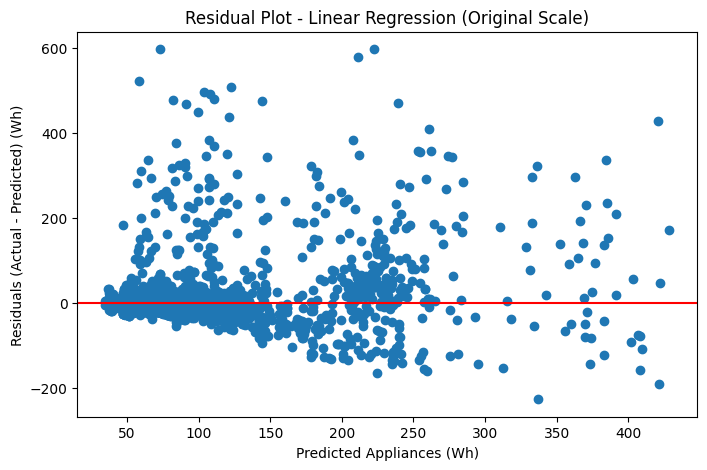

In [ ]:
# Residual plot on ORIGINAL scale
y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred_log)
residuals = y_true - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted Appliances (Wh)")
plt.ylabel("Residuals (Actual - Predicted) (Wh)")
plt.title("Residual Plot - Linear Regression (Original Scale)")
plt.show()


In [ ]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

y_pred_log = ridge_model.predict(X_test_scaled)

mae_ridge, rmse_ridge, r2_ridge = metrics_on_original_scale(y_test, y_pred_log)

print("Ridge Regression Results (trained on log1p target, reported on original scale):")
print("MAE:", mae_ridge)
print("RMSE:", rmse_ridge)
print("R2:", r2_ridge)


Ridge Regression Results (trained on log1p target, reported on original scale):
MAE: 26.94193565214972
RMSE: 68.86462818779354
R2: 0.3851816627861625


In [ ]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

y_pred_log = lasso_model.predict(X_test_scaled)

mae_lasso, rmse_lasso, r2_lasso = metrics_on_original_scale(y_test, y_pred_log)

print("Lasso Regression Results (trained on log1p target, reported on original scale):")
print("MAE:", mae_lasso)
print("RMSE:", rmse_lasso)
print("R2:", r2_lasso)


Lasso Regression Results (trained on log1p target, reported on original scale):
MAE: 26.84974774967577
RMSE: 68.83808648487211
R2: 0.3856554962009031


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_log = rf_model.predict(X_test)

mae_rf, rmse_rf, r2_rf = metrics_on_original_scale(y_test, y_pred_log)

print("Random Forest Results (trained on log1p target, reported on original scale):")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R2:", r2_rf)


Random Forest Results (trained on log1p target, reported on original scale):
MAE: 28.001361901905174
RMSE: 59.24479069977692
R2: 0.5449545909630675


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor

tscv = TimeSeriesSplit(n_splits=5)

rf_cv = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(
    rf_cv,
    X_train,
    y_train,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)

print("Random Forest TimeSeries CV R2 scores:", cv_scores)
print("Mean TimeSeries CV R2:", cv_scores.mean())

Random Forest TimeSeries CV R2 scores: [0.60426955 0.62611174 0.6792875  0.71485023 0.69766278]
Mean TimeSeries CV R2: 0.6644363597568692


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

tscv = TimeSeriesSplit(n_splits=3)

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

rs = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=12,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)

print("Best Parameters:", rs.best_params_)
print("Best TimeSeries CV R2:", rs.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}
Best TimeSeries CV R2: 0.6907860617100816


In [ ]:
# --- Train Tuned Random Forest using best parameters from RandomizedSearch ---
best_rf = RandomForestRegressor(
    n_estimators=rs.best_params_["n_estimators"],
    min_samples_split=rs.best_params_["min_samples_split"],
    min_samples_leaf=rs.best_params_["min_samples_leaf"],
    max_features=rs.best_params_["max_features"],
    max_depth=rs.best_params_["max_depth"],
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)
y_pred_log = best_rf.predict(X_test)

mae_best_rf, rmse_best_rf, r2_best_rf = metrics_on_original_scale(y_test, y_pred_log)

print("Tuned Random Forest Results (trained on log1p target, reported on original scale):")
print("MAE:", mae_best_rf)
print("RMSE:", rmse_best_rf)
print("R2:", r2_best_rf)


Tuned Random Forest Results (trained on log1p target, reported on original scale):
MAE: 24.48471009403735
RMSE: 59.10695109936447
R2: 0.5470695553428133


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# HistGradientBoosting is often stronger/faster than classic GradientBoosting on tabular data
tscv = TimeSeriesSplit(n_splits=3)

param_dist = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 6, None],
    "max_leaf_nodes": [31, 63, 127],
    "min_samples_leaf": [10, 20, 50, 100],
    "l2_regularization": [0.0, 0.1, 1.0]
}

rs_hgb = RandomizedSearchCV(
    HistGradientBoostingRegressor(early_stopping=True, random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring="r2",
    cv=tscv,
    n_jobs=-1,
    random_state=42
)

rs_hgb.fit(X_train, y_train)

print("Best HGB params:", rs_hgb.best_params_)
print("Best CV R2 (log target):", rs_hgb.best_score_)

best_hgb = rs_hgb.best_estimator_
y_pred_log = best_hgb.predict(X_test)

mae_hgb, rmse_hgb, r2_hgb = metrics_on_original_scale(y_test, y_pred_log)

print("\nHistGradientBoosting Results (trained on log1p target, reported on original scale):")
print("MAE:", mae_hgb)
print("RMSE:", rmse_hgb)
print("R2:", r2_hgb)


Best HGB params: {'min_samples_leaf': 100, 'max_leaf_nodes': 63, 'max_depth': 4, 'learning_rate': 0.03, 'l2_regularization': 0.1}
Best CV R2 (log target): 0.6986074761696841

HistGradientBoosting Results (trained on log1p target, reported on original scale):
MAE: 23.592940710968875
RMSE: 59.84194563655348
R2: 0.5357351451029357


In [ ]:
results = pd.DataFrame({
    "Model": ["Linear", "Ridge", "Lasso", "Random Forest", "Gradient Boosting"],
    "MAE": [mae, mae_ridge, mae_lasso, mae_best_rf, mae_hgb],
    "RMSE": [rmse, rmse_ridge, rmse_lasso, rmse_best_rf, rmse_hgb],
    "R2": [r2, r2_ridge, r2_lasso, r2_best_rf, r2_hgb]
})

results

,Model,MAE,RMSE,R2
0,Linear,26.944525,68.871570,0.385058
1,Ridge,26.941936,68.864628,0.385182
2,Lasso,26.849748,68.838086,0.385655
3,Random Forest,24.484710,59.106951,0.547070
4,Gradient Boosting,23.592941,59.841946,0.535735


`To define “energy waste” in measurable terms, we treat the model’s prediction as a baseline for expected appliance energy use under given environmental and temporal conditions.`

- **Predicted baseline**: the model’s expected energy consumption (Wh).
- **Energy waste**: **Actual − Predicted > 0** (positive residual), meaning usage is higher than expected.
- **Relative efficiency**: **Actual − Predicted < 0** (negative residual), meaning usage is lower than expected.

`This definition allows waste/efficiency to be quantified objectively using model residuals.`

`Linear Regression and Ridge Regression explained approximately 38–39% of the variance in appliance energy consumption, indicating that purely linear relationships are insufficient to capture the complexity of household energy usage. Although multicollinearity was observed among temperature features in the correlation heatmap, Ridge regression did not meaningfully improve performance compared to standard linear regression. This suggests that nonlinear structure and feature interactions, rather than coefficient instability, are the primary limitations of linear modeling in this dataset.`

`In contrast, Random Forest Regression achieved an R² of approximately 0.55, reducing both MAE and RMSE substantially. This suggests that nonlinear relationships and feature interactions between environmental and temporal variables play a significant role in predicting energy consumption.`

`These results indicate that household appliance energy use is influenced by complex behavioral and environmental dynamics rather than simple linear effects. Smart-home energy optimization strategies should therefore consider nonlinear modeling approaches for more accurate forecasting and efficiency analysis.`

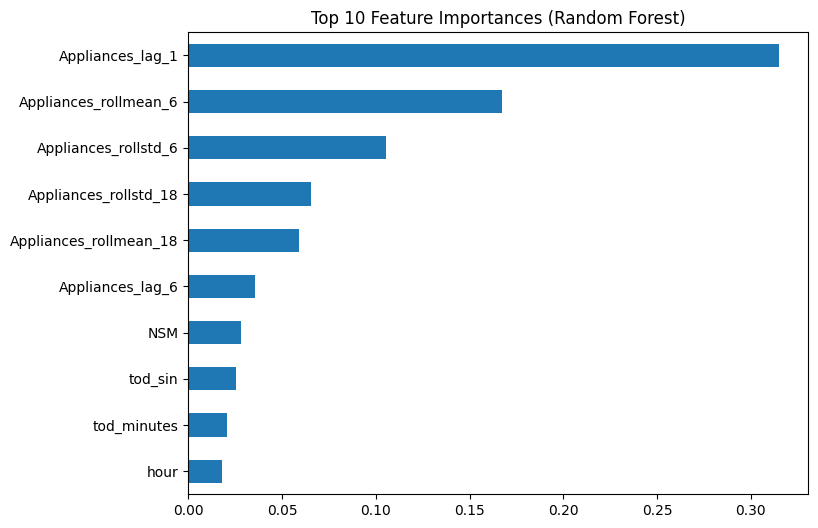

In [ ]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
top_features.sort_values().plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

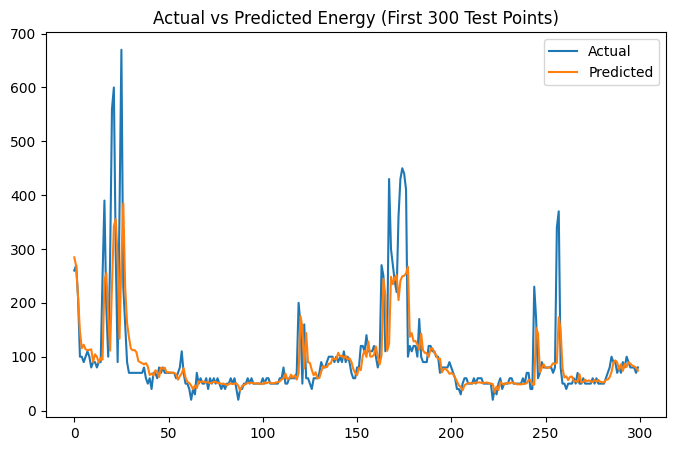

In [ ]:
y_pred_rf_log = best_rf.predict(X_test)
y_pred_best_rf = np.expm1(y_pred_rf_log)

plt.figure(figsize=(8,5))
plt.plot(y_true.values[:300], label="Actual")
plt.plot(y_pred_best_rf[:300], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Energy (First 300 Test Points)")
plt.show()